# Neural Network Classification with PyTorch

In [1]:
import sklearn # type: ignore

In [2]:
from sklearn.datasets import make_circles # type: ignore

In [3]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"Print 5 samples of X:\n {X[:5]}")
print(f"Print 5 samples of y:\n {y[:5]}")

Print 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Print 5 samples of y:
 [1 1 1 1 0]


In [6]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0],
                        "X2":X[:, 1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [7]:
import matplotlib.pyplot as plt

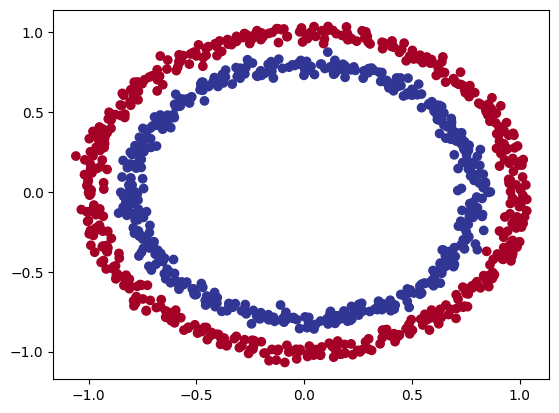

In [8]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu);


In [9]:
import plotly.express as px

# Assuming the variable "fig" holds your figure object
fig = px.scatter(circles, x=X[:, 0], y=X[:, 1], color=y, color_continuous_scale='RdYlBu')

# Output the figure in the Jupyter Notebook
fig.show()

In [10]:
import torch
torch.__version__

'2.2.1'

In [11]:
type(X)

numpy.ndarray

In [12]:
# Convert the data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Buiding Model
import torch
from torch import nn


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [17]:
model_0 = CircleModelV0().to(device)
model_0,device

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 'cuda')

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5914, -0.2946],
                      [-0.2858, -0.5921],
                      [-0.6519,  0.1871],
                      [-0.5952,  0.2854],
                      [ 0.6970,  0.5497]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1672, -0.4923, -0.3073, -0.5089, -0.0285], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1383,  0.1447,  0.2251,  0.0440, -0.3905]], device='cuda:0')),
             ('1.bias', tensor([-0.0053], device='cuda:0'))])

In [21]:
# make Predicitions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of Predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of Testing Data: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of Predictions: 200, Shape: torch.Size([200, 1])
Length of Testing Data: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1775],
        [-0.4150],
        [ 0.2408],
        [-0.2952],
        [-0.0837],
        [-0.2261],
        [-0.6378],
        [-0.5944],
        [ 0.2538],
        [-0.4345]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.1)

In [23]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1775],
        [-0.4150],
        [ 0.2408],
        [-0.2952],
        [-0.0837]], device='cuda:0', grad_fn=<SliceBackward0>)

In [25]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4557],
        [0.3977],
        [0.5599],
        [0.4267],
        [0.4791]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [26]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70992, Accuracy: 48.12% | Test Loss: 0.69821, Test Accuracy: 53.00%
Epoch: 10 | Loss: 0.70366, Accuracy: 48.50% | Test Loss: 0.69375, Test Accuracy: 53.50%
Epoch: 20 | Loss: 0.70043, Accuracy: 49.12% | Test Loss: 0.69192, Test Accuracy: 52.50%
Epoch: 30 | Loss: 0.69851, Accuracy: 48.88% | Test Loss: 0.69116, Test Accuracy: 53.00%
Epoch: 40 | Loss: 0.69725, Accuracy: 49.12% | Test Loss: 0.69086, Test Accuracy: 53.50%
Epoch: 50 | Loss: 0.69634, Accuracy: 49.50% | Test Loss: 0.69080, Test Accuracy: 53.50%
Epoch: 60 | Loss: 0.69566, Accuracy: 49.62% | Test Loss: 0.69085, Test Accuracy: 53.50%
Epoch: 70 | Loss: 0.69514, Accuracy: 49.62% | Test Loss: 0.69097, Test Accuracy: 53.50%
Epoch: 80 | Loss: 0.69473, Accuracy: 49.75% | Test Loss: 0.69112, Test Accuracy: 54.00%
Epoch: 90 | Loss: 0.69440, Accuracy: 49.75% | Test Loss: 0.69130, Test Accuracy: 54.00%


In [29]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


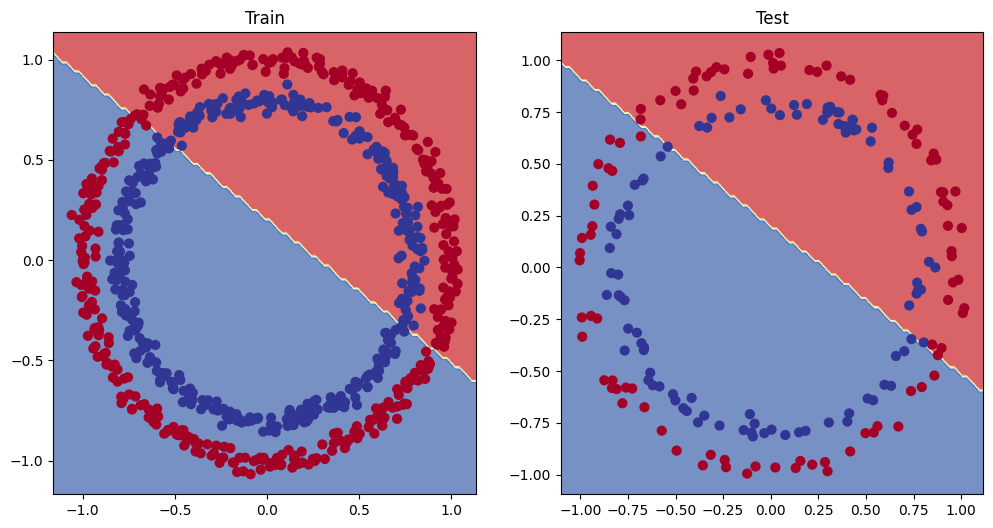

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Imporving a model (from a model perspective)
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from hidden units to 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- change the loss function
- Use transfer learning

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.Layer_2 = nn.Linear(in_features=10, out_features=10)
        self.Layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.Layer_3(self.Layer_2(self.layer_1(x)))
    

model_1 = CircleModelV1().to(device)
model_1

        
            

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (Layer_2): Linear(in_features=10, out_features=10, bias=True)
  (Layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('Layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training
    model_1.train()
    ## 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    ## Calcualte the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    ## Optimizer zero grad
    optimizer.zero_grad()
    
    ## Loss backword
    loss.backward()
    # Optimizer seup
    optimizer.step()
    
    # Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred = test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test Accuracy: 48.00%


Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


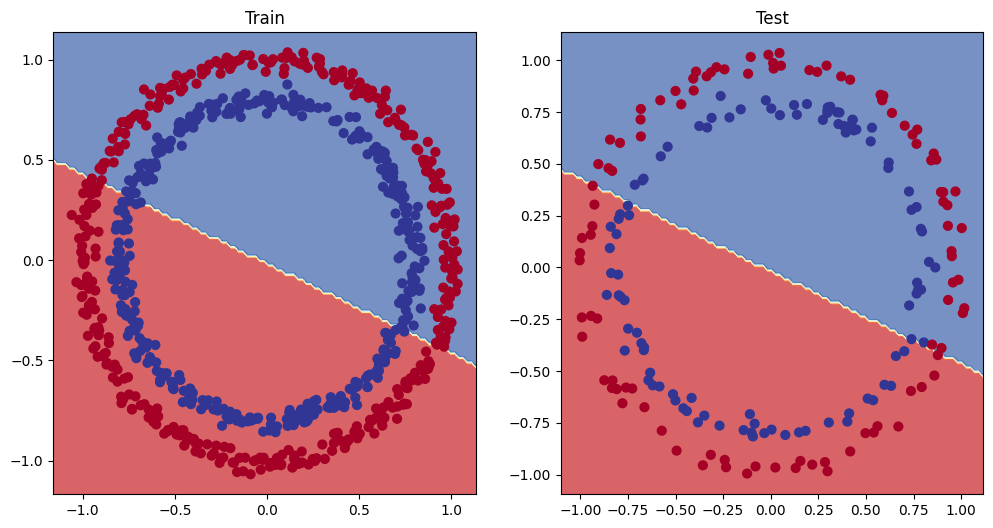

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can model a straight line
Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [36]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


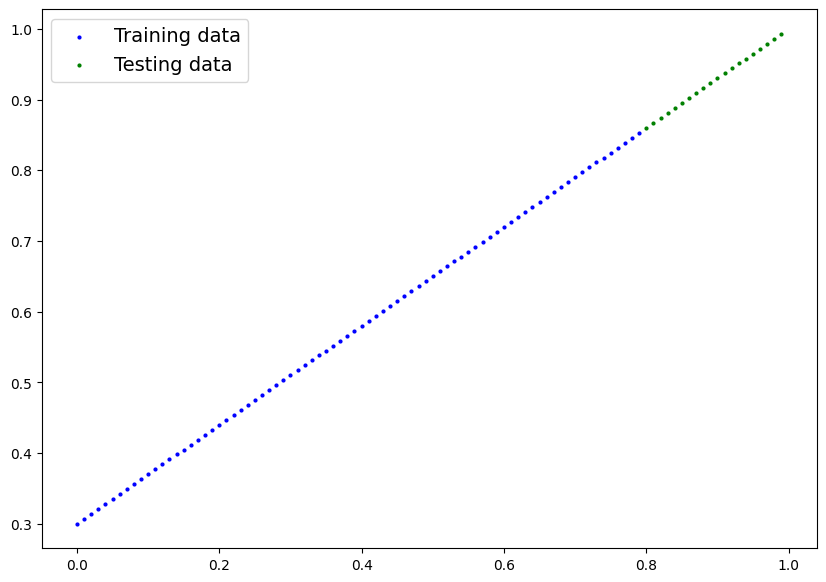

In [38]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [39]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [41]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_test_regression)
    loss = loss_fn(y_pred, y_test_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.95396, Test loss: 0.89656
Epoch: 100 | Loss: 0.05354, Test loss: 0.01133
Epoch: 200 | Loss: 0.05279, Test loss: 0.00909
Epoch: 300 | Loss: 0.04727, Test loss: 0.01196
Epoch: 400 | Loss: 0.04835, Test loss: 0.00834
Epoch: 500 | Loss: 0.04991, Test loss: 0.00444
Epoch: 600 | Loss: 0.03683, Test loss: 0.01586
Epoch: 700 | Loss: 0.03956, Test loss: 0.01113
Epoch: 800 | Loss: 0.04290, Test loss: 0.00802
Epoch: 900 | Loss: 0.02491, Test loss: 0.02384


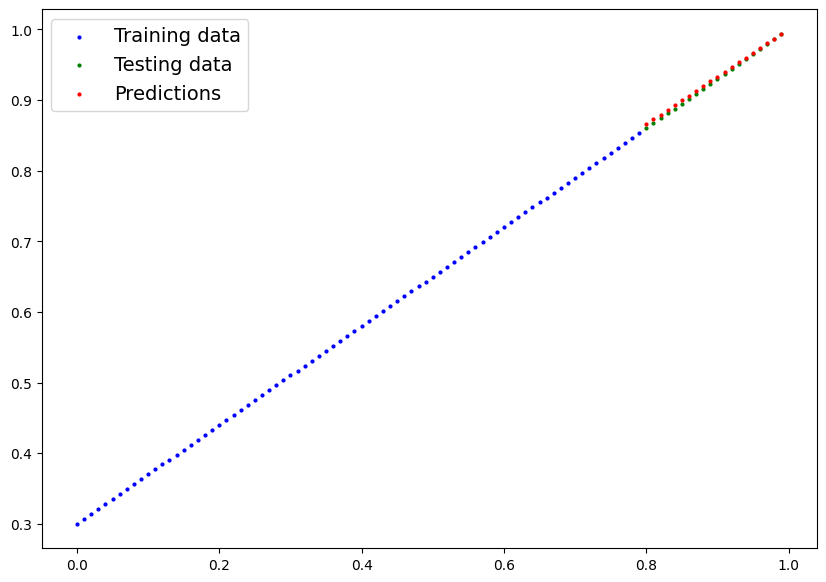

In [42]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

### Recreating non-linear data (red and blue circles)

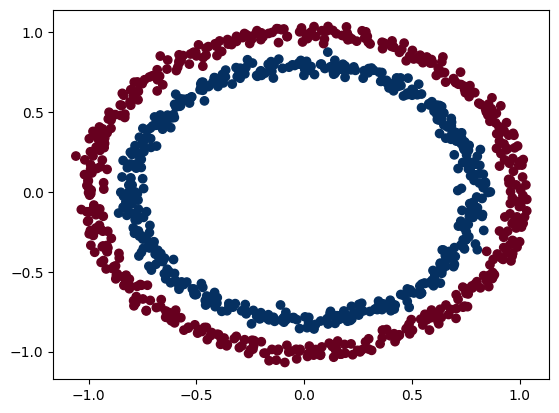

In [43]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [44]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [45]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [46]:
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [47]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Training a model with non-linearity

In [49]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred = y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [50]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] 

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

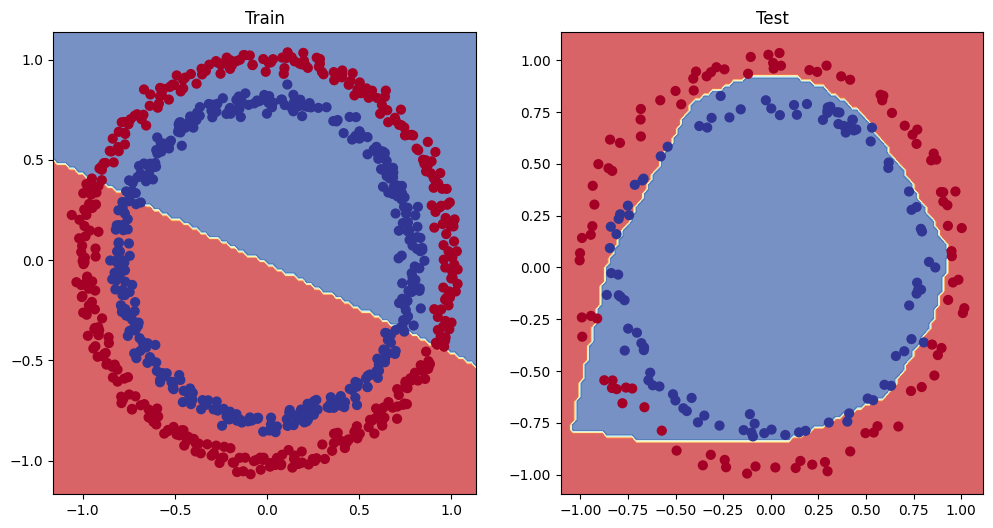

In [51]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

##  Putting things together by building a multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


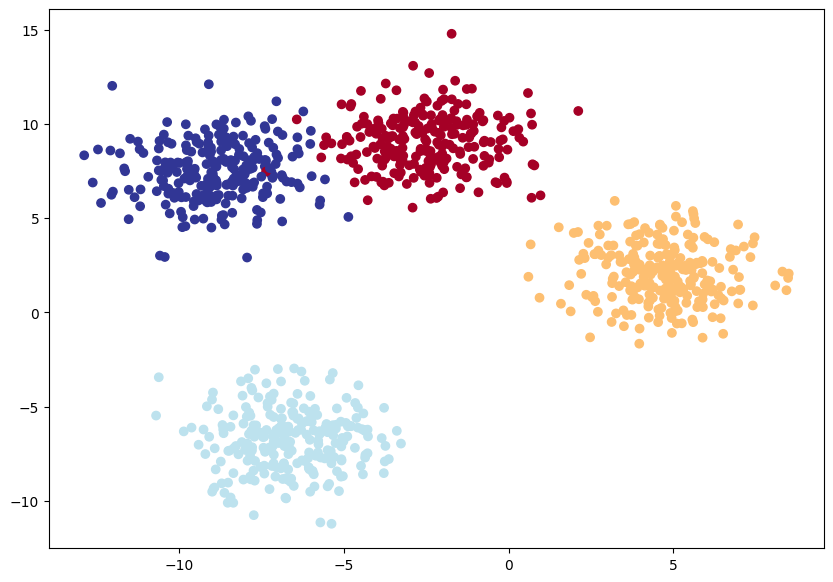

In [32]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [33]:
import plotly.express as px

# Convert tensors back to numpy arrays for Plotly
X_blob_np = X_blob.numpy()
y_blob_np = y_blob.numpy()

# Create a DataFrame for Plotly
import pandas as pd
data = pd.DataFrame({'Feature 1': X_blob_np[:, 0], 'Feature 2': X_blob_np[:, 1], 'Label': y_blob_np})

# Plot using Plotly
fig = px.scatter(data, x='Feature 1', y='Feature 2', color='Label', title='Blob Data', 
                 labels={'Label': 'Class'})
fig.show()


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [35]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [36]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) 

In [38]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [39]:
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_blob_test.to(device))
y_preds[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [40]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [41]:
y_logits  =model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [42]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [43]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [45]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [48]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test , y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test Loss: 0.57861, Test Accuracy: 95.50%
Epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test Loss: 0.13037, Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test Loss: 0.07216, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test Loss: 0.05133, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test Loss: 0.04098, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test Loss: 0.03486, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test Loss: 0.03083, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test Loss: 0.02799, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test Loss: 0.02587, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test Loss: 0.02423, Test Accuracy: 99.50%


In [54]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [56]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [58]:
from helper_functions import plot_predictions, plot_decision_boundary

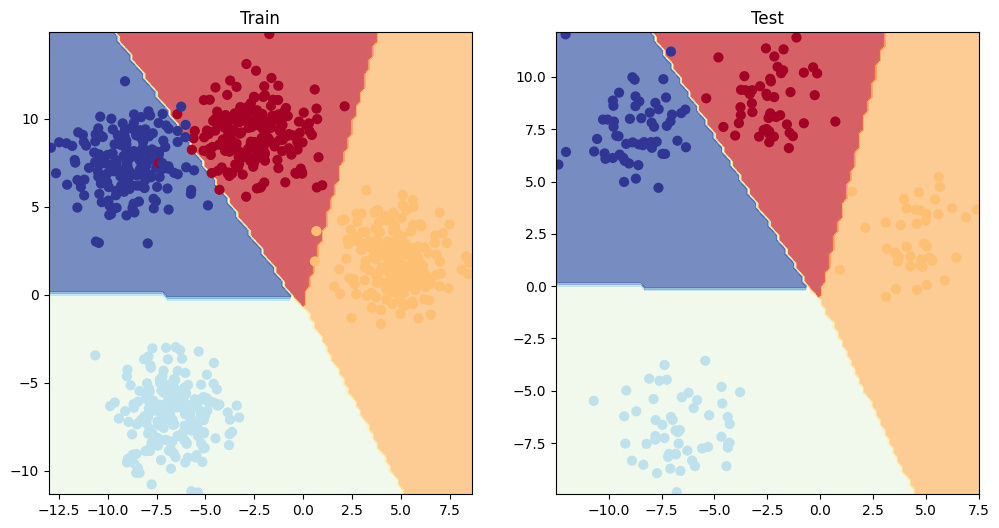

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)